In [1]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import numpy as np
import matplotlib.pyplot as plt
import sys
import gzip
from pyfaidx import Fasta
import RNA
import pandas as pd
import seaborn as sns
import scipy.stats as spstats

sys.path.append("..")
from analysis.visualize.utils_contactmap import parse_structure
from analysis.validation.evaluate_AUC import create_binarized_map

### KARR-seq, PARIS and RIC-seq using RNAduplex
Characterizing differences among KARR-seq, PARIS and RIC-seq. We separated chimeric reads into 3 categories: chimeric reads that overlap secondary structure (secondary), chimeric reads that overlap the binarized matrix and everything else (novel). We then apply RNAduplex of 15-nt pairs from the chimeric segments and measure each minimum free energies.  

In [2]:
def get_size(f_size):
    dict_sizes = {}
    with open(f_size, "r") as f:
        for line in f:
            row = line.strip("\r\n").split("\t")
            dict_sizes[row[0]] = int(row[1])
    return dict_sizes

def calc_mfe(chrom, struct, datum_truth,
             ss_intxn, ts_intxn, novel_intxn, p_method, f_pairs, p_read_threshold, p_res,
             o_fasta):

    for f_pair in f_pairs:
        
        with gzip.open(f_pair, "rt") as f:

            for line in f:
                row = line.strip("\r\n").split("\t")
                iid, c1, s1, c2, s2, l1, l2 = row[0], row[1], int(row[2]), row[3], int(row[4]), int(row[9]), int(row[10])
                e1 = s1 + l1
                e2 = s2 + l2


                if c1 == c2 and c1 == chrom:
                    
                    seq1 = str(o_fasta[c1]).upper()
                    seq2 = str(o_fasta[c2]).upper()
                    read1, read2 = seq1[s1:e1], seq2[s2:e2]

                    if len(read1) >= p_read_threshold and len(read2) >= p_read_threshold:
                        read1_sub = read1[-p_read_threshold:]
                        read2_sub = read2[:p_read_threshold]
                    else:
                        continue

                    fold = RNA.duplexfold(read1_sub, read2_sub)
                    ss = fold.structure.replace("&", "")
                    fe = fold.energy


                    if struct[e1//p_res, s2//p_res] > 0:
                        ss_intxn.append(("Secondary", fe, p_method))
                    elif datum_truth[e1//p_res, s2//p_res] > 0:
                        ts_intxn.append(("Tertiary", fe, p_method))
                    else:
                        novel_intxn.append(("Novel", fe, p_method))


### TERC

In [3]:
f_dot = "../analysis/rnaduplex/TERC_RNApdbee.dot"
chrom = "NR_001566"
p_res = 5

f_size = "../data/reference/hg19/hg19_refseq_wo_version.sizes"
f_fasta = "../data/reference/hg19/hg19_refseq_wo_version.fasta"
o_fasta = Fasta(f_fasta)

f_KARRseq = "../data/ligated/se/hrefseq/MAPQ1_SPAN0/G1_kethoxal-HEK293T_M13_B01.dedup.pairs.gz"
f_PARIS = "../data/ligated/se/hrefseq/MAPQ1_SPAN0/PARIS-HEK293T_B97_B01.nodedup.pairs.gz"
f_RICseq = "../data/ligated/se/hrefseq/MAPQ1_SPAN0/RIC-HeLa-rRNA-_M94_B01.dedup.pairs.gz"

f_KARRseq_txt_R01 = "../data/pairs/se/hrefseq/MAPQ1_SPAN0/G1_kethoxal-HEK293T_M13_R01.dedup.txt.gz"
f_KARRseq_txt_R02 = "../data/pairs/se/hrefseq/MAPQ1_SPAN0/G1_kethoxal-HEK293T_M13_R01.dedup.txt.gz"

f_PARIS_txt_R01 = "../data/pairs/se/hrefseq/MAPQ1_SPAN0/PARIS-HEK293T_B97_R01.nodedup.txt.gz"
f_PARIS_txt_R02 = "../data/pairs/se/hrefseq/MAPQ1_SPAN0/PARIS-HEK293T_B97_R02.nodedup.txt.gz"

f_RICseq_txt_R01 = "../data/pairs/se/hrefseq/MAPQ1_SPAN0/RIC-HeLa-rRNA-_M94_R01.dedup.txt.gz"
f_RICseq_txt_R02 = "../data/pairs/se/hrefseq/MAPQ1_SPAN0/RIC-HeLa-rRNA-_M94_R02.dedup.txt.gz"

(91, 91) (91, 91)


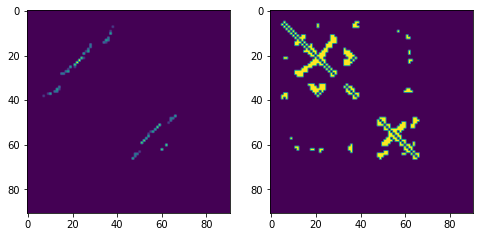

In [4]:
p_gamma_k = [6]
p_mean_u = 20
p_labels = ["KARR-seq"]

sizes = get_size(f_size)
m_bins = (sizes[chrom]//p_res)+1
bins = (m_bins, m_bins)

datum_truth = create_binarized_map("TERC", bins, p_resolution=p_res, k=p_gamma_k[0], p_mean_u=p_mean_u)

struct = parse_structure(f_dot, p_res, "full")

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(struct)
ax[1].imshow(datum_truth)

print(datum_truth.shape, struct.shape)

In [5]:
ss_intxn = []
ts_intxn = []
novel_intxn = []
shuffled_intxn = []

p_read_threshold = 15

f_pairs_karrseq = [f_KARRseq_txt_R01, f_KARRseq_txt_R02]
f_pairs_paris = [f_PARIS_txt_R01, f_PARIS_txt_R02]
f_pairs_ricseq = [f_RICseq_txt_R01, f_RICseq_txt_R02]

calc_mfe(chrom, struct, datum_truth, ss_intxn, ts_intxn, novel_intxn, "KARR-seq", f_pairs_karrseq, p_read_threshold, p_res, o_fasta)
calc_mfe(chrom, struct, datum_truth, ss_intxn, ts_intxn, novel_intxn, "PARIS", f_pairs_paris, p_read_threshold, p_res, o_fasta)
calc_mfe(chrom, struct, datum_truth, ss_intxn, ts_intxn, novel_intxn, "RIC-seq", f_pairs_ricseq, p_read_threshold, p_res, o_fasta)

df = pd.DataFrame(ss_intxn + ts_intxn + novel_intxn + shuffled_intxn)
df.columns = ["Category", "MFE", "Method"]

print(df[df.Method=="KARR-seq"].shape, df[df.Method=="PARIS"].shape, df[df.Method=="RIC-seq"].shape)

(338, 3) (33, 3) (78, 3)


Text(0.5, 1.0, 'TERC')

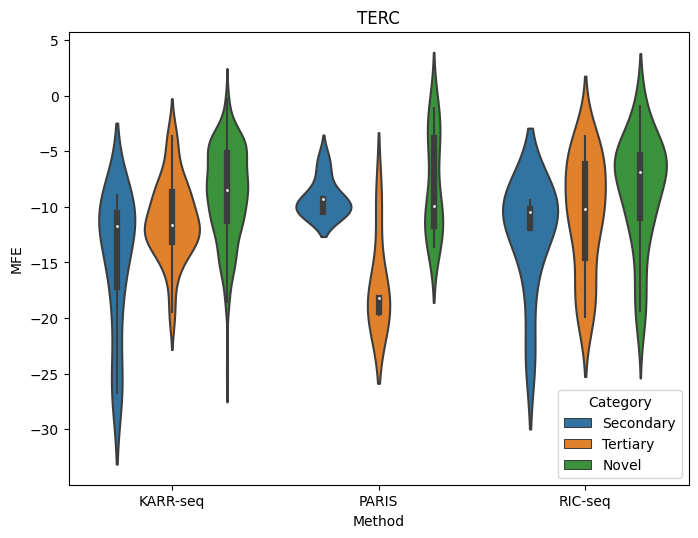

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
sns.violinplot(data=df, x="Method", y="MFE", hue="Category", ax=ax)
ax.set_xlabel("Method")
ax.set_ylabel("MFE")
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["KARR-seq", "PARIS", "RIC-seq"])
ax.set_title("TERC")

### U1

In [7]:
f_dot = "../analysis/rnaduplex/hsnrna-RNU1-1.dot"
chrom = "hsnrna-RNU1-1"
p_res = 5

f_size = "../data/reference/canonical_h+y/homo-s288c.mix.sizes"
f_fasta = "../data/reference/canonical_h+y/homo-s288c.mix.fa"
o_fasta = Fasta(f_fasta)

f_KARRseq = "../data/ligated/se/hcanonical_h+y/MAPQ1_SPAN0/G1_kethoxal-K562_M15_B01.dedup.pairs.gz"
f_PARIS = "../data/ligated/se/hcanonical_h+y/MAPQ1_SPAN0/PARIS-HEK293T_M97_B01.nodedup.pairs.gz"
f_RICseq = "../data/ligated/se/hcanonical_h+y/MAPQ1_SPAN0/RIC-HeLa-rRNA-_M94_B01.dedup.pairs.gz"

f_KARRseq_txt_R01 = "../data/pairs/se/hcanonical_h+y/MAPQ1_SPAN0/G1_kethoxal-K562_M15_R01.dedup.txt.gz"
f_KARRseq_txt_R02 = "../data/pairs/se/hcanonical_h+y/MAPQ1_SPAN0/G1_kethoxal-K562_M15_R01.dedup.txt.gz"

f_PARIS_txt_R01 = "../data/pairs/se/hcanonical_h+y/MAPQ1_SPAN0/PARIS-HEK293T_M97_R01.nodedup.txt.gz"
f_PARIS_txt_R02 = " ../data/pairs/se/hcanonical_h+y/MAPQ1_SPAN0/PARIS-HEK293T_M97_R02.nodedup.txt.gz"

f_RICseq_txt_R01 = "../data/pairs/se/hcanonical_h+y/MAPQ1_SPAN0/RIC-HeLa-rRNA-_M94_R01.dedup.txt.gz"
f_RICseq_txt_R02 = "../data/pairs/se/hcanonical_h+y/MAPQ1_SPAN0/RIC-HeLa-rRNA-_M94_R02.dedup.txt.gz"

(33, 33) (33, 33)


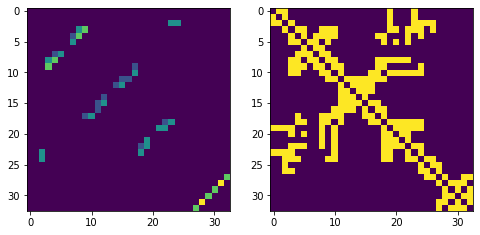

In [8]:
p_gamma_k = [6]
p_mean_u = 20
p_labels = ["KARR-seq"]

sizes = get_size(f_size)
m_bins = (sizes[chrom]//p_res)+1
bins = (m_bins, m_bins)

datum_truth = create_binarized_map("U1", bins, p_resolution=p_res, k=p_gamma_k[0], p_mean_u=p_mean_u)

struct = parse_structure(f_dot, p_res, "full")

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(struct)
ax[1].imshow(datum_truth)

print(datum_truth.shape, struct.shape)

In [9]:
ss_intxn = []
ts_intxn = []
novel_intxn = []
shuffled_intxn = []

p_read_threshold = 15

f_pairs_karrseq = [f_KARRseq_txt_R01, f_KARRseq_txt_R02]
f_pairs_paris = [f_PARIS_txt_R01, f_PARIS_txt_R02]
f_pairs_ricseq = [f_RICseq_txt_R01, f_RICseq_txt_R02]

calc_mfe(chrom, struct, datum_truth, ss_intxn, ts_intxn, novel_intxn, "KARR-seq", f_pairs_karrseq, p_read_threshold, p_res, o_fasta)
calc_mfe(chrom, struct, datum_truth, ss_intxn, ts_intxn, novel_intxn, "PARIS", f_pairs_paris, p_read_threshold, p_res, o_fasta)
calc_mfe(chrom, struct, datum_truth, ss_intxn, ts_intxn, novel_intxn, "RIC-seq", f_pairs_ricseq, p_read_threshold, p_res, o_fasta)

df = pd.DataFrame(ss_intxn + ts_intxn + novel_intxn + shuffled_intxn)
df.columns = ["Category", "MFE", "Method"]

print(df[df.Method=="KARR-seq"].shape, df[df.Method=="PARIS"].shape, df[df.Method=="RIC-seq"].shape)

(3338, 3) (107003, 3) (2403, 3)


Text(0.5, 1.0, 'U1')

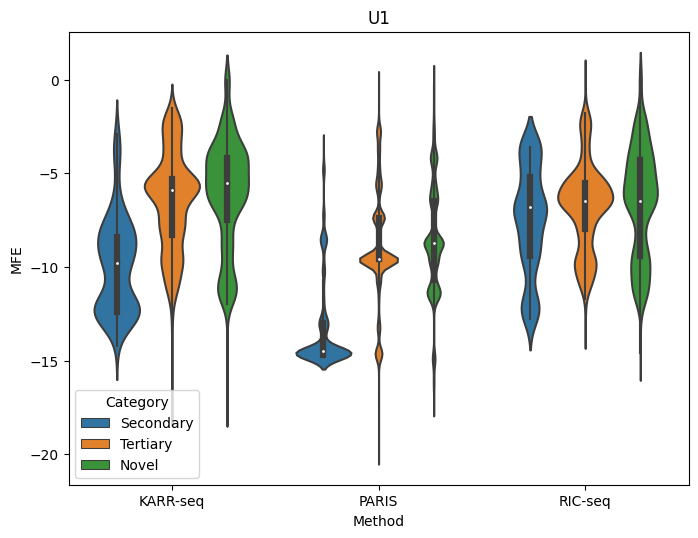

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
sns.violinplot(data=df, x="Method", y="MFE", hue="Category", ax=ax)
ax.set_xlabel("Method")
ax.set_ylabel("MFE")
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["KARR-seq", "PARIS", "RIC-seq"])
ax.set_title("U1")